In [3]:
import sys
import german
import heart
import wine
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
# import random
import classifiers
from itertools import combinations
from matplotlib import pylab as pl
import numpy as np
%matplotlib inline

## Readme

Kernel set is specified in `get_classifier_specs()` procedure. `get_data` returns a dictionary like `{"dataset_name":(X, Y), ...}`. Margins are calculated for each kernel via `SVC.decision.function()` method

__Note__: INK-spline SVM learning process usually takes a lot of time.

In [4]:
def get_classifier_specs():
    """
    Procedure specifies interesting kernels that are observed in the project.
    If you want to change the set of classifiers, you are welcome to edit this function.
    Specs format available in docs and classifiers.py module
    :return: list of kernel specs, that are processed in get_classifiers()
    """
    specs = []
    specs.append(["linear"])
    specs.append(["poly", 2])
    specs.append(["poly", 3])
    specs.append(["poly", 4])
#     specs.append(["ink", 1, -3])
#     specs.append(["ink", 2, -3])
    for i in [0.0001, 0.001, 0.01, 0.1, 1]:
        specs.append((["rbf", i]))
    return specs

def get_data():
    """
    Loads data from processed sources
    :return: list of (X, y) tuples
    """
    data = []
    data.append(german.load())
    data.append(heart.load())
    data.append(wine.load())

    data_dict = {}
    for dataset in data:
        data_dict[dataset[2]] = (dataset[0], dataset[1])
    return data_dict

def train_clfs(clfs, X_train, Y_train):
    for clf in clfs:
        clf.fit(X_train, Y_train)
    return None

def get_margins(clfs, X_train):
    margins = np.zeros((X_train.shape[0], len(clfs)))
    for idx, clf in enumerate(clfs):
        margins[:, idx] = clf.decision_function(X_train)
    return margins

## SVM Distance

In [5]:
def clf_symdiff(clf1, clf2):
    sv_set1 = set(clf1.support_)
    sv_set2 = set(clf2.support_)
    return len(sv_set1 ^ sv_set2)

def clf_symdiff_normalized(clf1, clf2):
    sv_set1 = set(clf1.support_)
    sv_set2 = set(clf2.support_)
    return len(sv_set1 ^ sv_set2) / len(sv_set1 | sv_set2)

## Calculating and drawing here

In [72]:
CLF_DIFF_TYPES = {
    "sn": ("SV normalized symmetric difference", clf_symdiff_normalized),
    "s": ("SV symmetric difference", clf_symdiff)
}
def margin_cov_pic(margins, clfs, C, fig, diff_type = "sn"):
    diff = CLF_DIFF_TYPES[diff_type][1]
    clfs_num = len(clfs)
    covs_num = round(clfs_num * (clfs_num - 1) / 2)
    covs = np.zeros(covs_num)
    difs = np.zeros(covs_num)
    idx = 0
    for i in range(clfs_num):
        for j in range(i + 1, clfs_num):
            covs[idx] = np.corrcoef(margins[:, i], margins[:, j])[0, 1]
            difs[idx] = diff(clfs[i], clfs[j])
            idx += 1
    fig.scatter(difs, 1 - covs, marker='o', s=90, label="C = %f" % C, c=np.random.rand(3,1))
            
# def do_things(dataset, key):
#     folds = StratifiedKFold(dataset[1], shuffle=True, random_state=None, n_folds=5)
#     specs = get_classifier_specs()
#     clfs = classifiers.get(specs, C=100)
#     for train, test in folds:
#         X_train, X_test = dataset[0][train], dataset[0][test]
#         Y_train, Y_test = dataset[1][train], dataset[1][test]
#         train_clfs(clfs, X_train, Y_train)
#         margins = get_margins(clfs, X_train)
#         margin_cov_pic(margins, clfs)

In [73]:
def spec_repr(spec):
    ret = "Kernel type: "
    if spec[0] == "linear":
        return ret + "linear"
    if spec[0] == "rbf":
        return ret + "rbf, gamma = %f" % spec[1]
    if spec[0] == "poly":
        return ret + "poly, degree = %d" % spec[1]
    if spec[0] == "ink":
        return ret + "ink, degree = %d, downer limit (a) = %f" % (spec[1], spec[2])

def print_kernel_info(C, clfs, specs, margins):
    print("C = %f" % C)
    for idx, clf in enumerate(clfs):
        print("%s\nSV number = %d" % (spec_repr(specs[idx]), clf.support_[0] + clf.support_[1]))
    print("")

def draw_corr_diff(dataset_name, C_list=[1.0], diff_type = "sn"):
    data = get_data()
    dataset = data[dataset_name]
    specs = get_classifier_specs()
    fig = pl.figure(figsize=(8, 6), dpi=150)
    ax1 = fig.add_subplot(111)
    for C in C_list:
        clfs = classifiers.get(specs, C=C)
        train_clfs(clfs, dataset[0], dataset[1])
        margins = get_margins(clfs, dataset[0])
        print_kernel_info(C, clfs, specs, margins)
        margin_cov_pic(margins, clfs, C, ax1, diff_type=diff_type)
    pl.legend(loc='upper left')
    pl.xlabel(CLF_DIFF_TYPES[diff_type][0])
    pl.ylabel("Margin vectors correlation")
    pl.show()

## Wine dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


C = 0.100000
Kernel type: linear
SV number = 21
Kernel type: poly, degree = 2
SV number = 21
Kernel type: poly, degree = 3
SV number = 21
Kernel type: poly, degree = 4
SV number = 21
Kernel type: rbf, gamma = 0.000100
SV number = 21
Kernel type: rbf, gamma = 0.001000
SV number = 21
Kernel type: rbf, gamma = 0.010000
SV number = 21
Kernel type: rbf, gamma = 0.100000
SV number = 21
Kernel type: rbf, gamma = 1.000000
SV number = 21

C = 1.000000
Kernel type: linear
SV number = 21
Kernel type: poly, degree = 2
SV number = 21
Kernel type: poly, degree = 3
SV number = 21
Kernel type: poly, degree = 4
SV number = 21
Kernel type: rbf, gamma = 0.000100
SV number = 21
Kernel type: rbf, gamma = 0.001000
SV number = 21
Kernel type: rbf, gamma = 0.010000
SV number = 21
Kernel type: rbf, gamma = 0.100000
SV number = 21
Kernel type: rbf, gamma = 1.000000
SV number = 21

C = 10.000000
Kernel type: linear
SV number = 21
Kernel type: poly, degree = 2
SV number = 21
Kernel type: poly, degree = 3
SV numbe

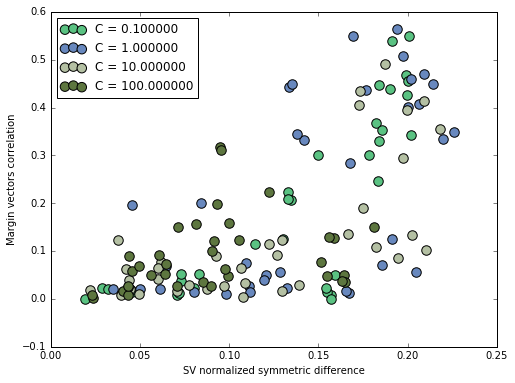

In [76]:
draw_corr_diff("wine", [0.1, 1, 10, 100])

## German dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


C = 0.100000
Kernel type: linear
SV number = 8
Kernel type: poly, degree = 2
SV number = 8
Kernel type: poly, degree = 3
SV number = 8
Kernel type: poly, degree = 4
SV number = 8
Kernel type: rbf, gamma = 0.000100
SV number = 8
Kernel type: rbf, gamma = 0.001000
SV number = 8
Kernel type: rbf, gamma = 0.010000
SV number = 8
Kernel type: rbf, gamma = 0.100000
SV number = 8
Kernel type: rbf, gamma = 1.000000
SV number = 8

C = 1.000000
Kernel type: linear
SV number = 8
Kernel type: poly, degree = 2
SV number = 8
Kernel type: poly, degree = 3
SV number = 8
Kernel type: poly, degree = 4
SV number = 8
Kernel type: rbf, gamma = 0.000100
SV number = 8
Kernel type: rbf, gamma = 0.001000
SV number = 8
Kernel type: rbf, gamma = 0.010000
SV number = 8
Kernel type: rbf, gamma = 0.100000
SV number = 8
Kernel type: rbf, gamma = 1.000000
SV number = 8

C = 10.000000
Kernel type: linear
SV number = 8
Kernel type: poly, degree = 2
SV number = 8
Kernel type: poly, degree = 3
SV number = 8
Kernel type: p

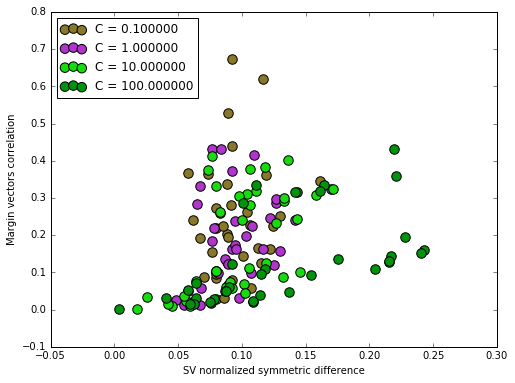

In [74]:
draw_corr_diff("german", [0.1, 1, 10, 100])

## Heart dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


C = 0.100000
Kernel type: linear
SV number = 3
Kernel type: poly, degree = 2
SV number = 5
Kernel type: poly, degree = 3
SV number = 5
Kernel type: poly, degree = 4
SV number = 5
Kernel type: rbf, gamma = 0.000100
SV number = 3
Kernel type: rbf, gamma = 0.001000
SV number = 5
Kernel type: rbf, gamma = 0.010000
SV number = 3
Kernel type: rbf, gamma = 0.100000
SV number = 3
Kernel type: rbf, gamma = 1.000000
SV number = 3

C = 1.000000
Kernel type: linear
SV number = 3
Kernel type: poly, degree = 2
SV number = 5
Kernel type: poly, degree = 3
SV number = 5
Kernel type: poly, degree = 4
SV number = 5
Kernel type: rbf, gamma = 0.000100
SV number = 5
Kernel type: rbf, gamma = 0.001000
SV number = 5
Kernel type: rbf, gamma = 0.010000
SV number = 3
Kernel type: rbf, gamma = 0.100000
SV number = 3
Kernel type: rbf, gamma = 1.000000
SV number = 7

C = 10.000000
Kernel type: linear
SV number = 7
Kernel type: poly, degree = 2
SV number = 3
Kernel type: poly, degree = 3
SV number = 3
Kernel type: p

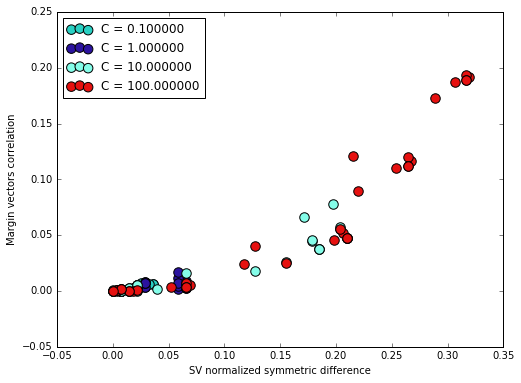

In [75]:
draw_corr_diff("heart", [0.1, 1, 10, 100])